# 導入相關套件

In [1]:
pip install numpy==1.24.4 pandas==1.5.3 hmmlearn==0.2.8 pyfolio hmmlearn

^C
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
import pyfolio as pf

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
import sys
import os
# 將 notebook 同層的 python 資料夾加入系統路徑
sys.path.insert(0, os.path.abspath("/Users/yangzherui/Desktop/py coding/因子研究/python"))
# 嘗試從 alpha_operator.py 匯入所有函數
from fuction import *


# 導入資料

In [4]:
data=pd.read_csv('/Users/yangzherui/Desktop/py coding/因子研究/data/APIPRCD.csv')###導入業師提供資料
data['mdate'] = pd.to_datetime(data['mdate'])###時間資料轉為時間格式
data.rename(columns= {'coid': 'symbol','mdate': 'datetime'}, inplace=True)###時間與股票代碼對其其她資料名稱
# 過濾出屬於 TWSE 且 symbol 為 4 碼數字的資料
TWSE_data = data[(data['mkt'] == 'TWSE') &(data['symbol'].astype(str).str.len() == 4) &(data['symbol'].astype(str).str.isdigit())]
TWSE_data = TWSE_data[(TWSE_data['symbol'].astype(int) >= 1101) &(TWSE_data['symbol'].astype(int) <= 9999)]
TWSE_data=TWSE_data.set_index(['datetime','symbol'])

/var/folders/cm/lmyc0cfx0wbdrgpk_h31077m0000gn/T/ipykernel_65357/3237688209.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data=pd.read_csv('/Users/yangzherui/Desktop/py coding/因子研究/data/APIPRCD.csv')###導入業師提供資料


In [5]:
market_data = pd.read_excel("/Users/yangzherui/Desktop/py coding/因子研究/data/twse.xlsx", skiprows=4)  # 視情況更改 skiprows 數字
del market_data['TWA00 加權指數']
market_data['日期'] = pd.to_datetime(market_data['日期'])
market_data.rename(columns= {'日期': 'datetime'}, inplace=True)###時間與股票代碼對其其她資料名稱
market_data=market_data.set_index(['datetime'])
market_data.sort_index(inplace=True)###時間排序
market_return=((market_data['收盤價']/market_data['收盤價'].shift(1))-1)

In [6]:
def get(columns):
    return TWSE_data[columns].unstack()

In [7]:
def get_strategy_aum_se(factor, aum=10_000_000, buy_fee=0.001425, sell_fee=0.004425, impact_coef=0.01,
                        plot_aum=True, plot_info=False, plot_signal=False, period='M'):
    import pandas as pd
    import numpy as np

    up_limit = ((get('open_d') - get('close_d').shift(1)) / get('close_d').shift(1)) > 0.095
    down_limit = ((get('open_d') - get('close_d').shift(1)) / get('close_d').shift(1)) < -0.095

    month_index = factor.groupby(factor.index.to_period(period)).tail(1).index

    position = (factor.rank(axis=1, ascending=False) <= 50).astype(int)
    weighting = resample_to_period(position.div(position.sum(axis=1), axis=0), period=period,index_data=get('close_d')).fillna(0)

    adj_open = get('open_d') * get('adjfac')
    daily_ret = adj_open.shift(-1) / adj_open - 1
    close = get('close_d')
    share = get('shares')

    index = weighting.index
    symbols = weighting.columns
    aum_se = pd.DataFrame(index=index, columns=['aum'])
    initial_weight = weighting.iloc[0].fillna(0)
    rebalance_size = pd.DataFrame(0, index=index, columns=symbols, dtype=float)
    units = 1000

    log_list = []

    for i, date in enumerate(index):
        today_reb = rebalance_size.loc[date].copy()
        limit_hit = up_limit.loc[date] | down_limit.loc[date]
        blocked = (today_reb != 0) & limit_hit
        today_reb[blocked] = 0

        price = close.loc[date]
        outstanding = share.loc[date]
        executed_weight = initial_weight.add(today_reb, fill_value=0)

        strategy_vols = (today_reb * aum) / (price * units)
        impact_cost = impact_coef * (strategy_vols / outstanding) ** 2
        buy_cost = today_reb.clip(lower=0) * buy_fee
        sell_cost = today_reb.clip(upper=0).abs() * sell_fee
        total_fees = (buy_cost + sell_cost + impact_cost).sum()

        reb_series = None
        is_order_day = False
        normal_order = False
        limit_retry = False
        buy_signals = {}
        sell_signals = {}

        if date in month_index:
            is_order_day = True
            normal_order = True

            target_weight = weighting.loc[date].fillna(0)
            lots = np.floor((target_weight * aum) / (price * units))
            new_weight = (lots * price * units) / aum
            reb_series = new_weight.sub(executed_weight, fill_value=0)

            blocked = (reb_series != 0) & limit_hit
            if blocked.any():
                target_weight[blocked] = 0
                if target_weight.sum() > 0:
                    target_weight = target_weight / target_weight.sum()
                    lots = np.floor((target_weight * aum) / (price * units))
                    new_weight = (lots * price * units) / aum
                    reb_series = new_weight.sub(executed_weight, fill_value=0)

            if i + 1 < len(index):
                next_date = index[i + 1]
                rebalance_size.loc[next_date] = reb_series

            utilize_rate = new_weight.sum()

            if plot_signal:
                buy_signals = reb_series[reb_series > 0].to_dict()
                sell_signals = reb_series[reb_series < 0].to_dict()

        elif blocked.any():
            limit_retry = True

            target_weight = initial_weight.copy()
            target_weight[blocked] = 0
            if target_weight.sum() > 0:
                target_weight = target_weight / target_weight.sum()
                lots = np.floor((target_weight * aum) / (price * units))
                new_weight = (lots * price * units) / aum
                reb_series = new_weight.sub(executed_weight, fill_value=0)

                if i + 1 < len(index):
                    next_date = index[i + 1]
                    rebalance_size.loc[next_date] = reb_series

                utilize_rate = new_weight.sum()

                if plot_signal:
                    buy_signals = reb_series[reb_series > 0].to_dict()
                    sell_signals = reb_series[reb_series < 0].to_dict()
            else:
                utilize_rate = executed_weight.sum()
        else:
            utilize_rate = executed_weight.sum()

        day_ret = (executed_weight * daily_ret.loc[date]).sum() - total_fees
        aum *= (1 + day_ret)
        aum_se.at[date, 'aum'] = aum

        if plot_info:
            print(f"{date} 倉位：", executed_weight[executed_weight > 0])
        if plot_aum:
            print(f"📅 日期: {date.date()} | 💰 AUM: {aum:,.2f} | 使用率: {utilize_rate:.4f}")

        log_list.append({
            'date': date,
            'aum': aum,
            'utilization': utilize_rate,
            'normal_order': normal_order,
            'limit_retry': limit_retry,
            'buy': buy_signals,
            'sell': sell_signals,
            'executed_weight': executed_weight.to_dict(),
            'raw_return': (executed_weight * daily_ret.loc[date]).sum(),
            'net_return': day_ret,
            'total_fees': total_fees,
            'blocked_symbols': limit_hit[limit_hit].index.tolist()  # 只保留 True 的 symbols
        })


        initial_weight = executed_weight

    log_df = pd.DataFrame(log_list).set_index('date')
    return aum_se, log_df


In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_compare_return(strategy_return, *comparison_returns, strategy_label='Strategy Return', comparison_labels=None):
    if isinstance(strategy_return, pd.DataFrame):
        if len(strategy_return.columns) == 1:
            strategy_return = strategy_return.iloc[:, 0]
        else:
            raise ValueError("strategy_return 必须是一个 Series 或只有一列的 DataFrame")

    cum_strategy = (1+strategy_return).cumprod()
    cum_returns = [(1+ret).cumprod() for ret in comparison_returns]
    MDD_series = cum_strategy.cummax() - cum_strategy

    plt.style.use('default')
    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax1.set_facecolor('#f7f4f4')

    cum_strategy.plot(label=strategy_label, ax=ax1, color='blue', linewidth=2, alpha=0.8)

    colors = ['black', 'deepskyblue', 'orange', 'limegreen', 'purple']
    for i, cum_return in enumerate(cum_returns):
        label = comparison_labels[i] if comparison_labels and i < len(comparison_labels) else f'Comparison Return {i+1}'
        cum_return.plot(label=label, ax=ax1, color=colors[i % len(colors)], linewidth=1.5)

    ax1.set_ylabel('Cumulative Return (%)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title('Return & Maximum Drawdown', fontsize=16)

    ax2 = ax1.twinx()
    ax2.plot(MDD_series.index, -MDD_series, label='Drawdown', color='saddlebrown', linestyle='--',
             linewidth=2, alpha=0.5, zorder=1)
    ax2.fill_between(MDD_series.index, -MDD_series, 0, color='saddlebrown', alpha=0.2, zorder=0)
    ax2.set_ylabel('Drawdown', fontsize=12)
    ax2.tick_params(axis='y')

    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

    ax1.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()


In [9]:
def calculate_metrics(returns: pd.Series, benchmark_returns: pd.Series = None) -> pd.Series:
    import empyrical as ep
    from scipy.stats import skew, kurtosis
    # 樣本起始與結束日期
    start_date = returns.index.min().strftime('%Y-%m-%d')
    end_date = returns.index.max().strftime('%Y-%m-%d')
    print('start_date:',start_date)
    print('end_date:',end_date)

    returns = returns.dropna()
    index_returns = ep.cum_returns(returns, starting_value=1.0)

    # 年化報酬率 (%)
    annual_return = round(ep.annual_return(returns) * 100, 2)

    # 年化波動率 (%)
    annual_volatility = round(ep.annual_volatility(returns) * 100, 2)

    # 夏普比率
    sharpe_ratio = round(ep.sharpe_ratio(returns), 2)

    # 索提諾比率
    sortino_ratio = round(ep.sortino_ratio(returns), 2)

    # 最大回撤 (%)
    max_drawdown = ep.max_drawdown(returns)
    mdd = round(max_drawdown * 100, 2)

    # 卡瑪比率
    calmar_ratio = round(ep.calmar_ratio(returns), 2)

    # 在市場上時間 (%)
    time_in_market = round((returns != 0).sum() / len(returns) * 100, 2)

    # 最長回撤日數
    drawdown = index_returns / index_returns.cummax() - 1
    drawdown_periods = (drawdown < 0).astype(int)
    longest_drawdown = drawdown_periods.groupby((drawdown_periods != drawdown_periods.shift()).cumsum()).sum().max()
    longest_drawdown = int(longest_drawdown)

    # Profit Factor
    positive_sum = returns[returns > 0].sum()
    negative_sum = returns[returns < 0].sum()
    profit_factor = round(abs(positive_sum / negative_sum), 2) if negative_sum != 0 else np.nan

    # 勝率計算
    daily_win_rate = round((returns > 0).sum() / (returns != 0).sum() * 100, 2) if (returns != 0).sum() > 0 else np.nan
    weekly_returns = ep.aggregate_returns(returns, convert_to='weekly')
    weekly_win_rate = round((weekly_returns > 0).sum() / len(weekly_returns) * 100, 2) if len(weekly_returns) > 0 else np.nan
    monthly_returns = ep.aggregate_returns(returns, convert_to='monthly')
    monthly_win_rate = round((monthly_returns > 0).sum() / len(monthly_returns) * 100, 2) if len(monthly_returns) > 0 else np.nan
    yearly_returns = ep.aggregate_returns(returns, convert_to='yearly')
    yearly_win_rate = round((yearly_returns > 0).sum() / len(yearly_returns) * 100, 2) if len(yearly_returns) > 0 else np.nan

    # 偏態與峰度
    skewness = round(skew(returns), 4)
    kurt = round(kurtosis(returns), 4)

    # Omega 比率
    omega_ratio = round(ep.omega_ratio(returns), 2)

    # Tail Ratio
    tail_ratio = round(ep.tail_ratio(returns), 2)

    performance = pd.Series({
        '年化收益率(%)': annual_return,
        '年化標準差(%)': annual_volatility,
        '年化夏普比率': sharpe_ratio,
        '索提諾比率': sortino_ratio,
        '卡瑪比率': calmar_ratio,
        '在市場上時間(%)': time_in_market,
        '最大回撤(MDD)(%)': mdd,
        '最長回撤日數': longest_drawdown,
        'Profit Factor': profit_factor,
        '日勝率(%)': daily_win_rate,
        '周勝率(%)': weekly_win_rate,
        '月勝率(%)': monthly_win_rate,
        '年勝率(%)': yearly_win_rate,
        '偏態(Skewness)': skewness,
        '峰度(Kurtosis)': kurt,
        'Omega 比率': omega_ratio,
        'Tail Ratio': tail_ratio
    })

    return performance

In [10]:
def rolling_hmm(window_size=500, lookback_days=120,random_state=42, market_return=market_return):
    market_data['半年線']=market_data['收盤價'].rolling(20*6).mean()
    market_data['年線']=market_data['收盤價'].rolling(252).mean()
    from tqdm import tqdm
    # 基础设定
    window_size = window_size           # 滑动窗口长度
    lookback_days = lookback_days          # 只回顾最后120天
    n_components = 2             # HMM隐状态数
    dates_valid = []             # 有效日期
    S1_pct_list = []             # 状态1占比
    S2_pct_list = []             # 状态2占比
    S1_flag_list = []            # 低波动状态标记
    S2_flag_list = []            # 高波动状态标记

    total_loops = range(window_size, len(market_return))
    for end in tqdm(total_loops, desc="Rolling HMM 執行中"):
        try:
            window_df = market_return.iloc[end - window_size:end]
            #window_df = market_data[['年線','半年線']].iloc[end - window_size:end]
            window_df = (window_df-window_df.mean())/window_df.std()
            if window_df.isna().any().any():
                print('有缺失值跳過')
                continue
            X = window_df.values
            # 資料標準化
            if X.ndim == 1:
                X = X.reshape(-1, 1)
            model = GaussianHMM(n_components=n_components,
                                covariance_type='full',
                                n_iter=10000,
                                tol=1e-4,
                                random_state=random_state)
            model.fit(X)
            states = model.predict(X)
            rets = market_return.iloc[end - window_size:end]

            S1 = rets[states == 0]
            S2 = rets[states == 1]

            if S1.std() > S2.std():
                S1_flag_list.append(1)
                S2_flag_list.append(0)
            else:
                S1_flag_list.append(0)
                S2_flag_list.append(1)

            S1_recent = states[-lookback_days:]
            S1_pct_list.append(np.mean(S1_recent == 0))
            S2_pct_list.append(np.mean(S1_recent == 1))

            dates_valid.append(market_return.index[end])

        except Exception as e:
            print(f"Error at index {end}: {e}")
            continue


    condition_pct_df = pd.DataFrame({"S1": S1_pct_list,"S2": S2_pct_list}, index=dates_valid)
    condition_df = pd.DataFrame({"S1": S1_flag_list,"S2": S2_flag_list}, index=dates_valid)
    return condition_pct_df,condition_df

# 基本資料

In [11]:
period='M'
#buy_fee=0.001425
#sell_fee=0.001425+0.003
#aum=10000000
#impact_coef=0.01
#topx=50

In [12]:
調整後收盤價=get('close_d')*get('adjfac')
低波動因子=1/((調整後收盤價/調整後收盤價.shift(1)-1).rolling(20*24).std())
動能因子=(調整後收盤價.shift(20*1)/調整後收盤價.shift(20*4)-1)
###因子池
factor_merge={}
factor_merge['低波動因子']=cs_clip(cs_zscore(低波動因子))
factor_merge['動能因子']=cs_clip(cs_zscore(動能因子))
factor_merge['市值因子']=cs_clip(cs_zscore(get('mktcap')))
factor_merge=pd.concat(factor_merge,axis=1)

In [13]:
調整後開盤價=(get('open_d')*get('adjfac')).shift(-1)
預期收益率＿日=(調整後開盤價.shift(-1)/調整後開盤價)-1

# 建構隱馬可夫鏈

##### 一、S1(state為0)&S2(state為1)
##### 二、TAIEX 之 500日報酬報酬於S1與S2下之標準差判斷S1及S2為高波動市場狀態或低波動市場狀態
##### 三、過去120日S1與S2出現日數除以120作為權重

#### 四、滾動日數超參數

In [14]:
condition_pct_df,condition_df = rolling_hmm(window_size=500, lookback_days=120,random_state=42)
weighting=pd.DataFrame()
weighting['高波動市場比率']=condition_pct_df[condition_df==1].sum(axis=1)
weighting['低波動市場比率']=condition_pct_df[condition_df==0].sum(axis=1)

Rolling HMM 執行中:   0%|          | 0/14106 [00:00<?, ?it/s]

有缺失值跳過


Rolling HMM 執行中:   4%|▍         | 602/14106 [00:17<04:57, 45.46it/s]Model is not converging.  Current: -652.2733956911022 is not greater than -652.273391356877. Delta is -4.3342251956346445e-06
Model is not converging.  Current: -652.1336986007047 is not greater than -652.1336944388381. Delta is -4.161866627327981e-06
Rolling HMM 執行中: 100%|██████████| 14106/14106 [10:27<00:00, 22.48it/s]


In [15]:
weighting.to_pickle('handler/hmm_prediction.pkl')

## 因子輪轉

## 等權重選擇得分前50大之股票

### 計算綜合因子

In [16]:
###高波動市場給低波動因子 vs 低波動市場給動能因子
weighting = weighting.rename(columns={'高波動市場比率': '低波動因子','低波動市場比率':'動能因子'})
weighting = weighting[['低波動因子','動能因子']]

In [17]:
eqw_mega_factor=cs_cdf(factor_merge['低波動因子']*0.5+factor_merge['動能因子']*0.5)*cs_cdf(factor_merge['市值因子'])
mega_factor=cs_cdf(factor_merge['低波動因子'].mul(weighting['低波動因子'],axis=0)+factor_merge['動能因子'].mul(weighting['動能因子'],axis=0))*cs_cdf(factor_merge['市值因子'])
mom_facor=cs_cdf(factor_merge['動能因子'])*cs_cdf(factor_merge['市值因子'])
lov_factor=cs_cdf(factor_merge['低波動因子'])*cs_cdf(factor_merge['市值因子'])

### 先偷偷存因子資料

In [18]:
panel_data = pd.concat({
    'MOM': mom_facor.stack(dropna=False),
    'LOV': lov_factor.stack(dropna=False),
}, axis=1, join='outer')

In [19]:
panel_data.to_pickle('/Users/yangzherui/Desktop/py coding/因子研究/data/hmm_raw_factor.pkl')

### 績效回測

In [ ]:
#倉位市值
aum_se, log_df=get_strategy_aum_se(factor=mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')#,plot_situation=True)
aum_se＿eqw, log_df_eqw=get_strategy_aum_se(factor=eqw_mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿mom, log_df_mom=get_strategy_aum_se(factor=mom_facor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿lov, log_df_lov=get_strategy_aum_se(factor=lov_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')

#return_se
return_se=(aum_se['aum']/aum_se['aum'].shift(1)-1)
return_se＿eqw=(aum_se＿eqw['aum']/aum_se＿eqw['aum'].shift(1)-1)
return_se＿mom=(aum_se＿mom['aum']/aum_se＿mom['aum'].shift(1)-1)
return_se＿lov=(aum_se＿lov['aum']/aum_se＿lov['aum'].shift(1)-1)

###合成績效資料
backtest_df=pd.DataFrame()
backtest_df['HMM']=return_se.shift(2)
backtest_df['EQW']=return_se＿eqw.shift(2)
backtest_df['MOM']=return_se＿mom.shift(2)
backtest_df['LOV']=return_se＿lov.shift(2)

backtest_df['MKT']=market_return
#market_return=market_return.loc['2008':'2025-04-28']
backtest_df=backtest_df.loc['2008':'2025-04-28'].fillna(0)

start_date: 2022-08-31
end_date: 2025-04-28


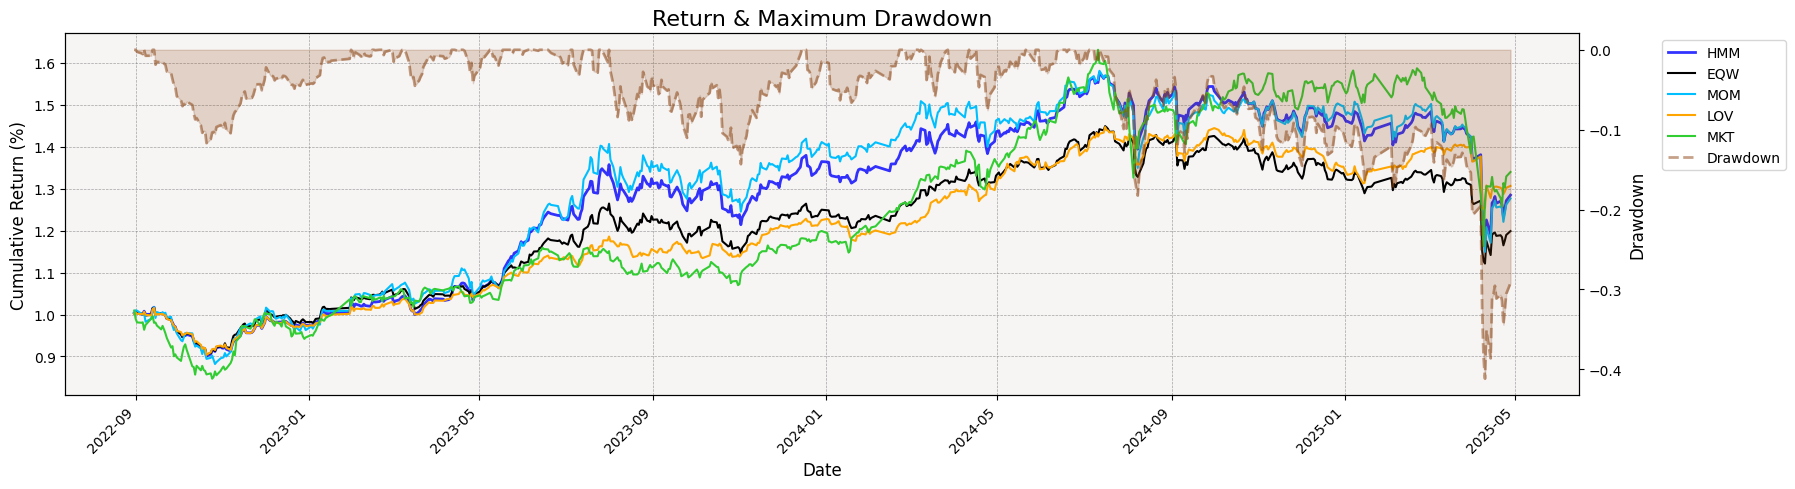

=========================================策略績效匯總（全樣本）================================================
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28


,年化收益率(%),年化標準差(%),年化夏普比率,索提諾比率,卡瑪比率,在市場上時間(%),最大回撤(MDD)(%),最長回撤日數,Profit Factor,日勝率(%),周勝率(%),月勝率(%),年勝率(%),偏態(Skewness),峰度(Kurtosis),Omega 比率,Tail Ratio
HMM,10.37,17.55,0.65,0.86,0.40,100.0,-26.12,188.0,1.13,55.78,55.80,63.64,50.0,-1.2571,12.1389,1.13,0.90
EQW,7.40,14.47,0.57,0.74,0.33,100.0,-22.61,186.0,1.11,55.31,53.62,57.58,50.0,-1.8792,20.1165,1.11,0.96
MOM,10.09,20.11,0.58,0.78,0.37,100.0,-27.30,188.0,1.11,55.78,55.80,54.55,50.0,-0.9896,8.4995,1.11,0.87
LOV,11.10,11.63,0.96,1.25,0.82,100.0,-13.61,186.0,1.20,55.78,60.87,60.61,50.0,-3.1935,41.1815,1.20,1.07
MKT,12.21,20.74,0.66,0.91,0.43,100.0,-28.69,189.0,1.13,56.09,54.35,57.58,50.0,-0.7592,11.9262,1.13,1.09


In [ ]:
###樣本內：'2008-6-18':'2022-08-31'
###樣本外：'2022-08-31':'2025-04-28'
###全樣本：'2008-6-18':'2025-04-28'
start_date = '2008-6-18'
end_date = '2022-08-31'
print('start_date:',start_date)
print('end_date:',end_date)
plot_compare_return(backtest_df['HMM'].loc[start_date:end_date], backtest_df['EQW'].loc[start_date:end_date],backtest_df['MOM'].loc[start_date:end_date],backtest_df['LOV'].loc[start_date:end_date],backtest_df['MKT'].loc[start_date:end_date],strategy_label='HMM',comparison_labels=['EQW','MOM','LOV','MKT'])
print('=========================================策略績效匯總（全樣本）================================================')
backtest_df.loc[start_date:end_date].apply(calculate_metrics).T

### 附錄-權重變化限制

In [22]:
def limit_weight_change(df: pd.DataFrame, max_change: float = 0.01) -> pd.DataFrame:
    df = df.copy()
    limited_df = df.iloc[:1].copy()  # 初始日不調整
    for i in range(1, len(df)):
        prev = limited_df.iloc[-1]
        curr = df.iloc[i]
        delta = curr - prev
        delta_clipped = delta.clip(-max_change, max_change)
        new_weight = prev + delta_clipped
        new_weight = new_weight / new_weight.sum()
        limited_df = pd.concat([limited_df, new_weight.to_frame().T])
    limited_df.index = df.index
    return limited_df


In [24]:
month_weighting=resample_to_period(weighting,period=period,index_data=get('close_d'))#.plot()

In [25]:
weight_dict={}

for limit in [0.2,0.4,0.6,1]:
     weight_dict[f'limit_{limit}']=limit_weight=limit_weight_change(month_weighting,max_change=limit)

weight_df=pd.concat(weight_dict,axis=1)

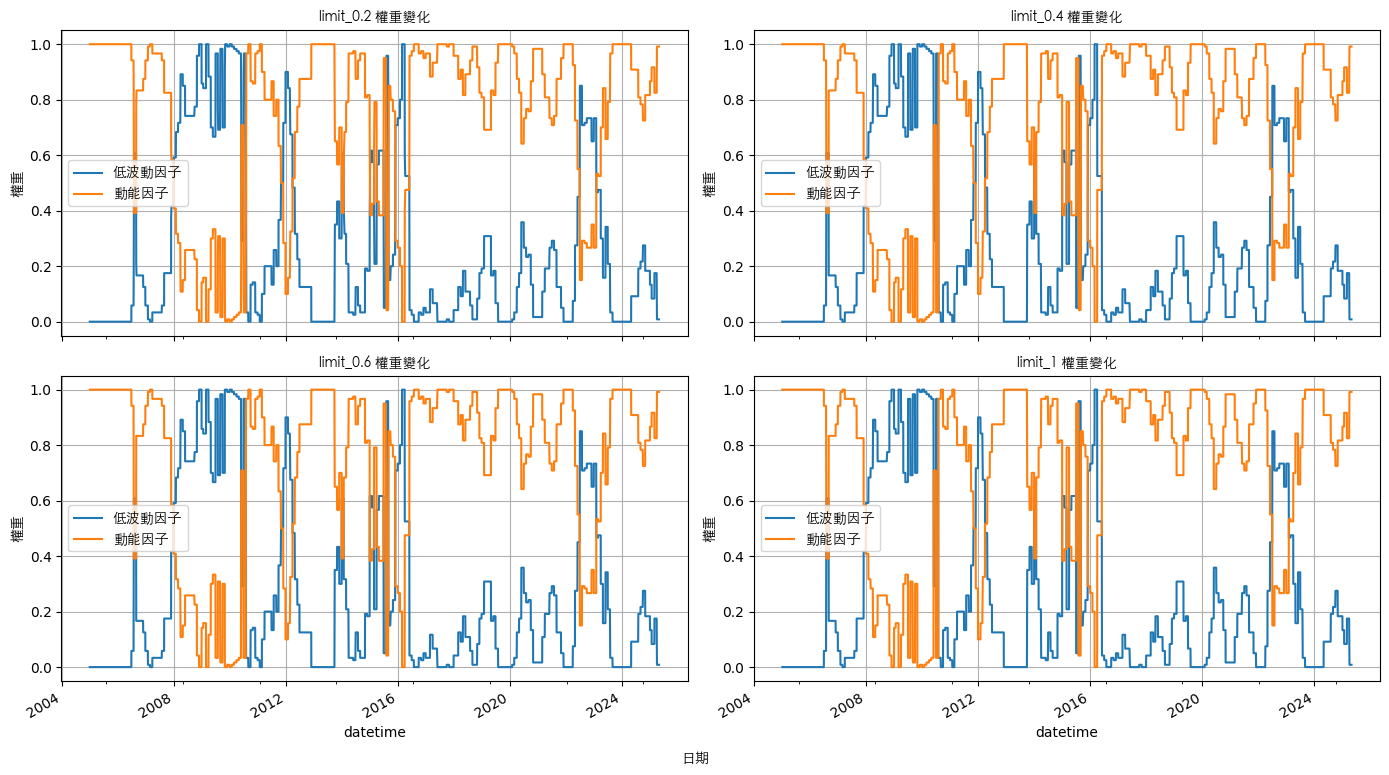

In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 設定中文字體
font_path = "/Users/yangzherui/Desktop/py coding/因子研究/STHeiti Light.ttc"
font_prop = fm.FontProperties(fname=font_path, size=10)

# 建立子圖
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)
axes = axes.flatten()

# limit 名稱
limits = ['limit_0.2', 'limit_0.4', 'limit_0.6', 'limit_1']

for i, limit in enumerate(limits):
    ax = axes[i]
    
    # 選取該 limit 下的兩個欄位
    df = weight_df[limit]
    
    # 畫線圖
    df.plot(ax=ax)
    
    # 設定標題與格式
    ax.set_title(f'{limit} 權重變化', fontproperties=font_prop)
    ax.set_ylabel('權重', fontproperties=font_prop)
    ax.legend(prop=font_prop)
    ax.grid(True)

# 共用的 x 軸標籤
fig.text(0.5, 0.04, '日期', ha='center', fontproperties=font_prop)
fig.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [27]:
mega_factor_dict={}

for columns in weight_df.columns.get_level_values(0).tolist():
    weighting=weight_df[columns]
    mega_factor_dict[columns]=cs_cdf(factor_merge['低波動因子'].mul(weighting['低波動因子'],axis=0)+factor_merge['動能因子'].mul(weighting['動能因子'],axis=0))*cs_cdf(factor_merge['市值因子'])

mega_factor_df=pd.concat(mega_factor_dict,axis=1)

In [ ]:
backtest_dict={}

for columns in mega_factor_df.columns.get_level_values(0).unique().tolist():
    aum_se, log_df=get_strategy_aum_se(factor=mega_factor_df[columns],aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
    backtest_dict[columns]=(aum_se['aum']/aum_se['aum'].shift(1)-1).shift(2)

backtest_df=pd.concat(backtest_dict,axis=1)

=========================================策略績效匯總（全樣本）================================================
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28


,年化收益率(%),年化標準差(%),年化夏普比率,索提諾比率,卡瑪比率,在市場上時間(%),最大回撤(MDD)(%),最長回撤日數,Profit Factor,日勝率(%),周勝率(%),月勝率(%),年勝率(%),偏態(Skewness),峰度(Kurtosis),Omega 比率,Tail Ratio
limit_0.2,9.57,19.07,0.58,0.78,0.2,100.0,-48.02,445.0,1.11,56.12,56.68,59.61,66.67,-0.6296,10.0266,1.11,0.87
limit_0.4,9.56,19.13,0.57,0.78,0.2,100.0,-48.05,445.0,1.11,56.17,56.80,59.61,66.67,-0.6268,10.0132,1.11,0.87
limit_0.6,9.54,19.16,0.57,0.78,0.2,100.0,-48.05,445.0,1.11,56.09,56.80,58.62,66.67,-0.6283,9.9352,1.11,0.87
limit_1,9.58,19.18,0.57,0.78,0.2,100.0,-48.05,445.0,1.11,56.05,56.80,59.11,66.67,-0.6306,9.9474,1.11,0.87


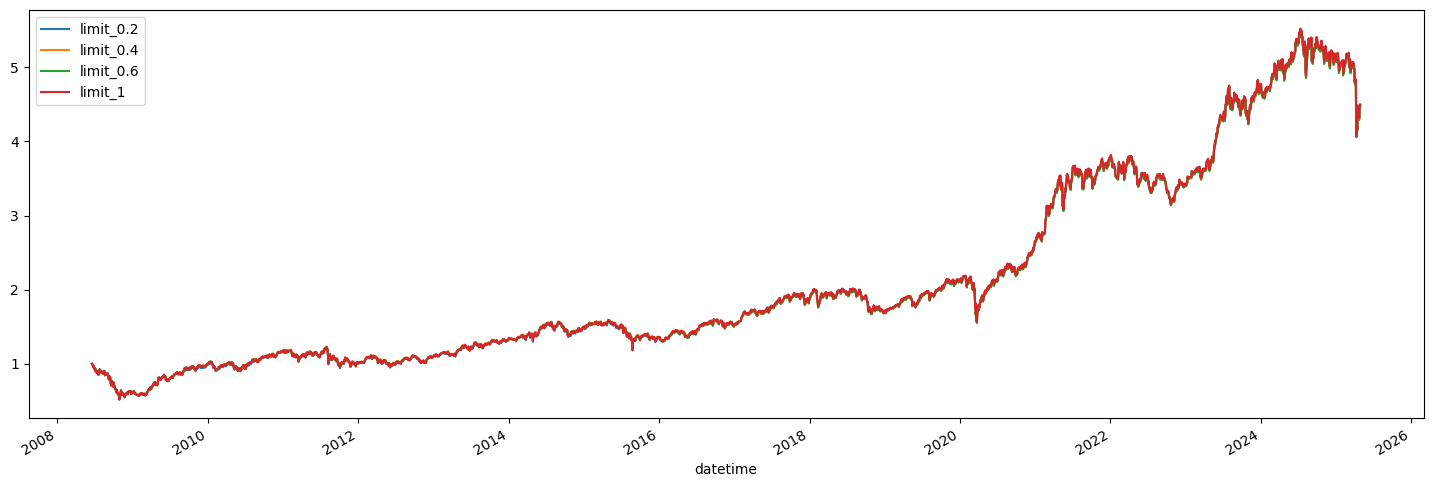

In [29]:
###樣本內：'2008-6-18':'2022-08-31'
###樣本外：'2022-08-31':'2025-04-28'
###全樣本：'2008-6-18':'2025-04-28'
start_date = '2008-6-18'
end_date = '2025-04-28'
(backtest_df+1).loc[start_date:end_date].cumprod().plot(figsize=(18,6))
print('=========================================策略績效匯總（全樣本）================================================')
backtest_df.loc[start_date:end_date].fillna(0).apply(calculate_metrics).T

# vix擇時

In [30]:
vix_data=pd.read_excel('/Users/yangzherui/Desktop/py coding/因子研究/data/vix.xlsx', skiprows=4)
del vix_data['VIX15 台指選擇權波動率指數(新5D)']
vix_data['日期'] = pd.to_datetime(vix_data['日期'])
vix_data.set_index(vix_data['日期'],inplace=True)
del vix_data['日期']
vix_data=vix_data.sort_index()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

/Users/yangzherui/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yangzherui/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yangzherui/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yangzherui/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/yangzherui/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 22577 (\N{CJK UNIFIED IDEOGRAPH-5831}) missing from font(s) DejaVu 

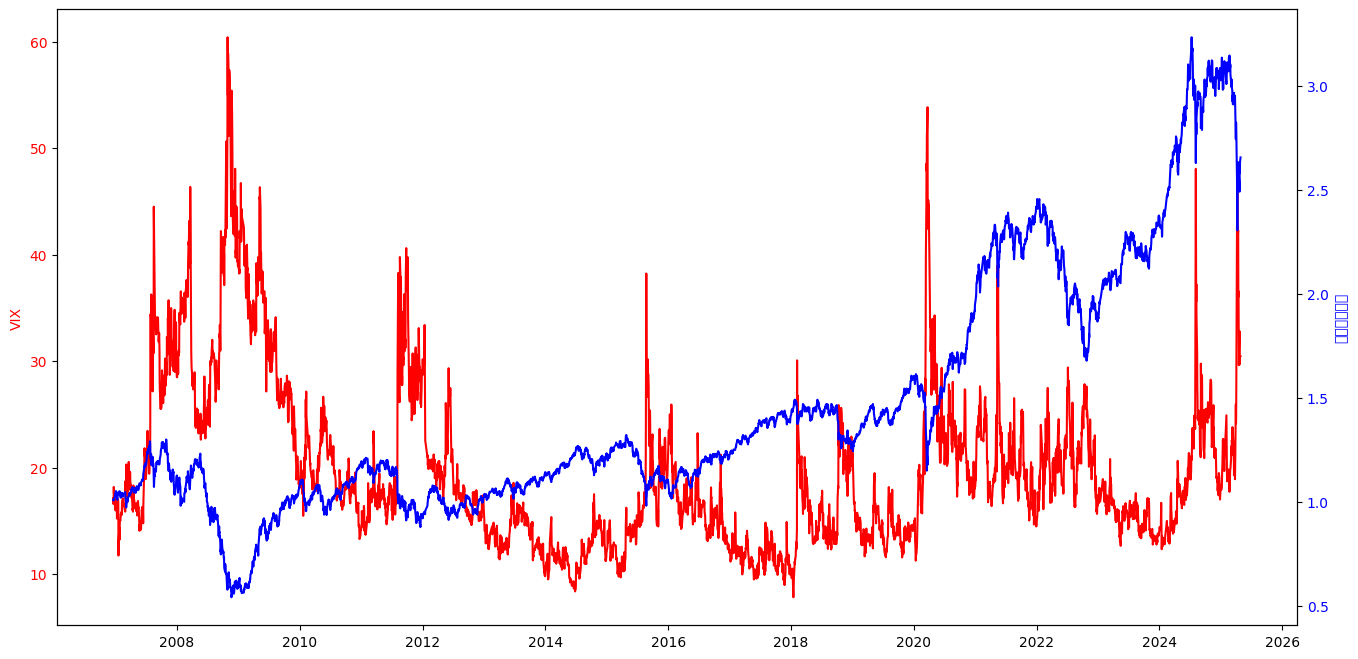

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import pandas as pd

fig, ax1 = plt.subplots(figsize=(16, 8))
# 字體設定
font_path = "/Users/yangzherui/Desktop/py coding/因子研究/STHeiti Light.ttc"
font = fm.FontProperties(fname=font_path, size=10)
# 危機區間列表
events = [
    ('1990-02-12', '1990-10-01', '證交稅實施', '#6A5ACD'),
    ('1995-01-05', '1995-08-15', '中共試射飛彈', '#6A5ACD'),
    ('1997-08-27', '1999-02-05', '亞洲金融風暴', '#8B0000'),
    ('2000-02-05', '2001-09-20', '網路泡沫', '#8B0000'),
    ('2003-01-24', '2003-04-28', 'SARS疫情', '#FFA500'),
    ('2004-03-19', '2004-08-05', '319槍擊案', '#6A5ACD'),
    ('2008-05-20', '2008-11-21', '次級房貸', '#8B0000'),
    ('2011-02-08', '2011-12-19', '美債危機', '#8B0000'),
    ('2015-04-28', '2015-08-24', '中國股災', '#1E90FF'),
    ('2018-10-02', '2019-01-04', '中美貿易戰', '#1E90FF'),
    ('2020-01-20', '2020-03-19', 'COVID-19疫情', '#FFA500'),
    ('2022-01-05', '2022-10-26', 'FED停止QE', '#1E90FF'),
    ('2025-02-21', '2025-04-09', '川普2.0', '#6A5ACD'),
]
# 設定繪圖區間
plot_start = pd.to_datetime('2006-12-18')
plot_end = pd.to_datetime('2025-04-28')
# 左側 Y 軸：VIX 收盤價
vix_plot = vix_data['收盤價'].loc[plot_start:plot_end]
ax1.plot(vix_plot, color='red', label='VIX 收盤價')
ax1.set_ylabel('VIX', color='red')
ax1.tick_params(axis='y', labelcolor='red')
# 右側 Y 軸：市場累積報酬
ax2 = ax1.twinx()
cumulative_return = (1 + market_return.loc[plot_start:plot_end]).cumprod()
ax2.plot(cumulative_return, color='blue', label='市場累積報酬')
ax2.set_ylabel('市場累積報酬', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
# 加入危機區間標註
for start, end, label, color in events:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    if start_dt <= plot_end and end_dt >= plot_start:
        ax1.axvspan(max(start_dt, plot_start), min(end_dt, plot_end), color=color, alpha=0.3)
        mid = max(start_dt, plot_start) + (min(end_dt, plot_end) - max(start_dt, plot_start)) / 2
        ax1.text(mid, ax1.get_ylim()[1]*0.9, label, ha='center', va='top', rotation=90, fontsize=9,
                 fontproperties=font, bbox=dict(facecolor='white', edgecolor='none', alpha=0.5))
# 標題與格式
ax1.set_title('VIX 收盤價 vs 市場累積報酬（含重大事件區間）', fontproperties=font, fontsize=14)
ax1.set_xlabel('日期',fontproperties=font, fontsize=14)
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.tight_layout()
plt.show()

In [ ]:
vix_weight = pd.DataFrame(index=vix_data.index)
vix_weight['LOV'] = ((vix_data['最高價'] > 30) | (vix_data['最高價'] <= 10)).astype(float)
vix_weight['MOM'] = ((vix_data['最高價'] <= 30) & (vix_data['最高價'] > 10)).astype(float)
vix_weight_sum = vix_weight.sum(axis=1)
vix_weight = vix_weight.div(vix_weight_sum, axis=0)

In [34]:
eqw_mega_factor=cs_cdf(factor_merge['低波動因子']*0.5+factor_merge['動能因子']*0.5)*cs_cdf(factor_merge['市值因子'])
mega_factor=cs_cdf(factor_merge['低波動因子'].mul(vix_weight['LOV'],axis=0)+factor_merge['動能因子'].mul(vix_weight['MOM'],axis=0))*cs_cdf(factor_merge['市值因子'])
mom_facor=cs_cdf(factor_merge['動能因子'])*cs_cdf(factor_merge['市值因子'])
lov_factor=cs_cdf(factor_merge['低波動因子'])*cs_cdf(factor_merge['市值因子'])

In [ ]:
#倉位市值
aum_se, log_df=get_strategy_aum_se(factor=mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿eqw, log_df＿eqw=get_strategy_aum_se(factor=eqw_mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿mom, log_df＿mom=get_strategy_aum_se(factor=mom_facor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿lov, log_df＿lov=get_strategy_aum_se(factor=lov_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')

#return_se
return_se=(aum_se['aum']/aum_se['aum'].shift(1)-1)
return_se＿eqw=(aum_se＿eqw['aum']/aum_se＿eqw['aum'].shift(1)-1)
return_se＿mom=(aum_se＿mom['aum']/aum_se＿mom['aum'].shift(1)-1)
return_se＿lov=(aum_se＿lov['aum']/aum_se＿lov['aum'].shift(1)-1)

###合成績效資料
backtest_df=pd.DataFrame()
backtest_df['vix']=return_se.shift(2)
backtest_df['EQW']=return_se＿eqw.shift(2)
backtest_df['MOM']=return_se＿mom.shift(2)
backtest_df['LOV']=return_se＿lov.shift(2)
backtest_df['MKT']=market_return
#market_return=market_return.loc['2008':'2025-04-28']
backtest_df=backtest_df.loc['2008-6-18':'2025-04-28'].fillna(0)

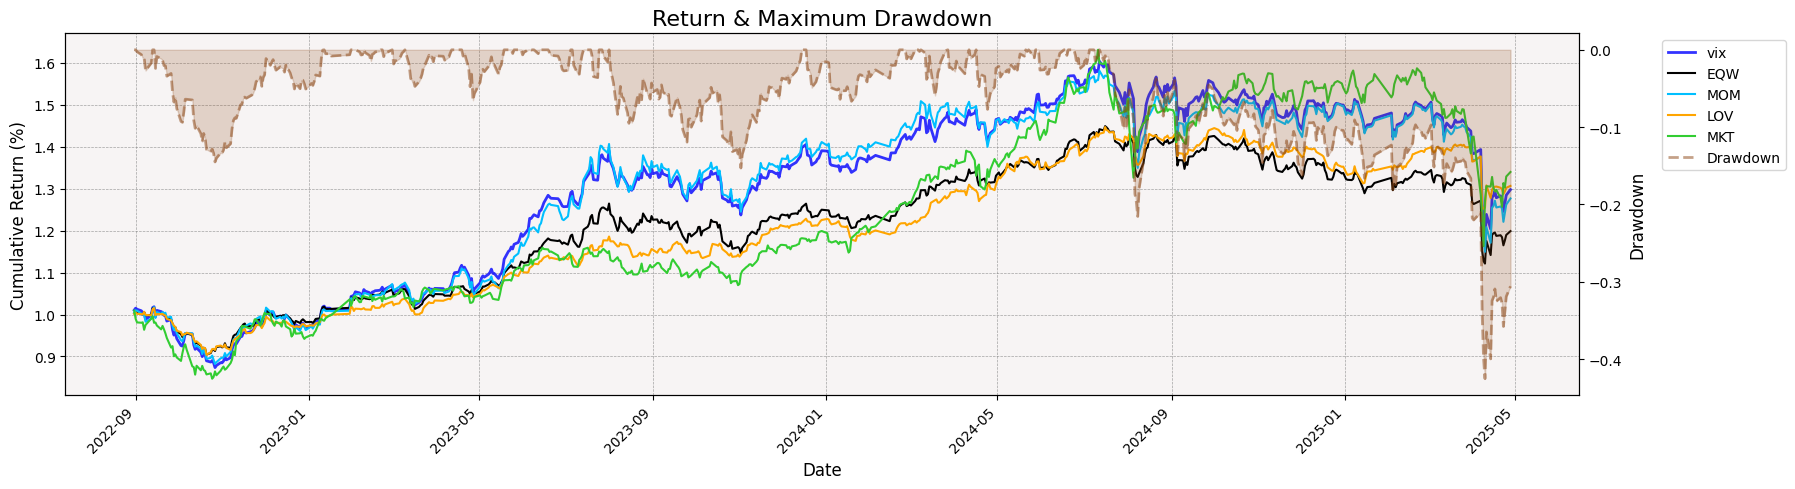

=========================================策略績效匯總（全樣本）================================================
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28


,年化收益率(%),年化標準差(%),年化夏普比率,索提諾比率,卡瑪比率,在市場上時間(%),最大回撤(MDD)(%),最長回撤日數,Profit Factor,日勝率(%),周勝率(%),月勝率(%),年勝率(%),偏態(Skewness),峰度(Kurtosis),Omega 比率,Tail Ratio
vix,10.81,19.04,0.63,0.85,0.41,100.0,-26.53,188.0,1.12,55.62,59.42,57.58,50.0,-1.1181,8.8507,1.12,0.93
EQW,7.40,14.47,0.57,0.74,0.33,100.0,-22.61,186.0,1.11,55.31,53.62,57.58,50.0,-1.8792,20.1165,1.11,0.96
MOM,10.09,20.11,0.58,0.78,0.37,100.0,-27.30,188.0,1.11,55.78,55.80,54.55,50.0,-0.9896,8.4995,1.11,0.87
LOV,11.10,11.63,0.96,1.25,0.82,100.0,-13.61,186.0,1.20,55.78,60.87,60.61,50.0,-3.1935,41.1815,1.20,1.07
MKT,12.21,20.74,0.66,0.91,0.43,100.0,-28.69,189.0,1.13,56.09,54.35,57.58,50.0,-0.7592,11.9262,1.13,1.09


In [36]:
###樣本內：'2008-6-18':'2022-08-31'
###樣本外：'2022-08-31':'2025-04-28'
###全樣本：'2008-6-18':'2025-04-28'

start_date='2022-08-31'
end_date='2025-04-28'

plot_compare_return(
    backtest_df['vix'].loc[start_date:end_date],
    backtest_df['EQW'].loc[start_date:end_date],
    backtest_df['MOM'].loc[start_date:end_date],
    backtest_df['LOV'].loc[start_date:end_date],
    backtest_df['MKT'].loc[start_date:end_date],
    strategy_label='vix',
    comparison_labels=['EQW', 'MOM', 'LOV', 'MKT']
)
print('=========================================策略績效匯總（全樣本）================================================')
backtest_df.loc[start_date:end_date].apply(calculate_metrics).T

# 雙均線市場擇時

In [37]:
weighting=pd.DataFrame()
weighting['高波動市場比率']=(((market_data['收盤價'].rolling(20*6).mean())-(market_data['收盤價'].rolling(252).mean()))<0).astype(float)
weighting['低波動市場比率']=(((market_data['收盤價'].rolling(20*6).mean())-(market_data['收盤價'].rolling(252).mean()))>0).astype(float)

In [38]:
###高波動市場給低波動因子 vs 低波動市場給動能因子
weighting = weighting.rename(columns={'高波動市場比率': '低波動因子','低波動市場比率':'動能因子'})
weighting = weighting[['低波動因子','動能因子']]

In [39]:
eqw_mega_factor=cs_cdf(factor_merge['低波動因子']*0.5+factor_merge['動能因子']*0.5)*cs_cdf(factor_merge['市值因子'])
mega_factor=cs_cdf(factor_merge['低波動因子'].mul(weighting['低波動因子'],axis=0)+factor_merge['動能因子'].mul(weighting['動能因子'],axis=0))*cs_cdf(factor_merge['市值因子'])
mom_facor=cs_cdf(factor_merge['動能因子'])*cs_cdf(factor_merge['市值因子'])
lov_factor=cs_cdf(factor_merge['低波動因子'])*cs_cdf(factor_merge['市值因子'])

In [ ]:
#倉位市值
aum_se, log_df=get_strategy_aum_se(factor=mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')#,plot_situation=True)
aum_se＿eqw, log_df_eqw=get_strategy_aum_se(factor=eqw_mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿mom, log_df_mom=get_strategy_aum_se(factor=mom_facor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿lov, log_df_lov=get_strategy_aum_se(factor=lov_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')

#return_se
return_se=(aum_se['aum']/aum_se['aum'].shift(1)-1)
return_se＿eqw=(aum_se＿eqw['aum']/aum_se＿eqw['aum'].shift(1)-1)
return_se＿mom=(aum_se＿mom['aum']/aum_se＿mom['aum'].shift(1)-1)
return_se＿lov=(aum_se＿lov['aum']/aum_se＿lov['aum'].shift(1)-1)

###合成績效資料
backtest_df=pd.DataFrame()
backtest_df['sma']=return_se.shift(2)
backtest_df['EQW']=return_se＿eqw.shift(2)
backtest_df['MOM']=return_se＿mom.shift(2)
backtest_df['LOV']=return_se＿lov.shift(2)

backtest_df['MKT']=market_return
#market_return=market_return.loc['2008':'2025-04-28']
backtest_df=backtest_df.loc['2008':'2025-04-28'].fillna(0)

start_date: 2022-08-31
end_date: 2025-04-28


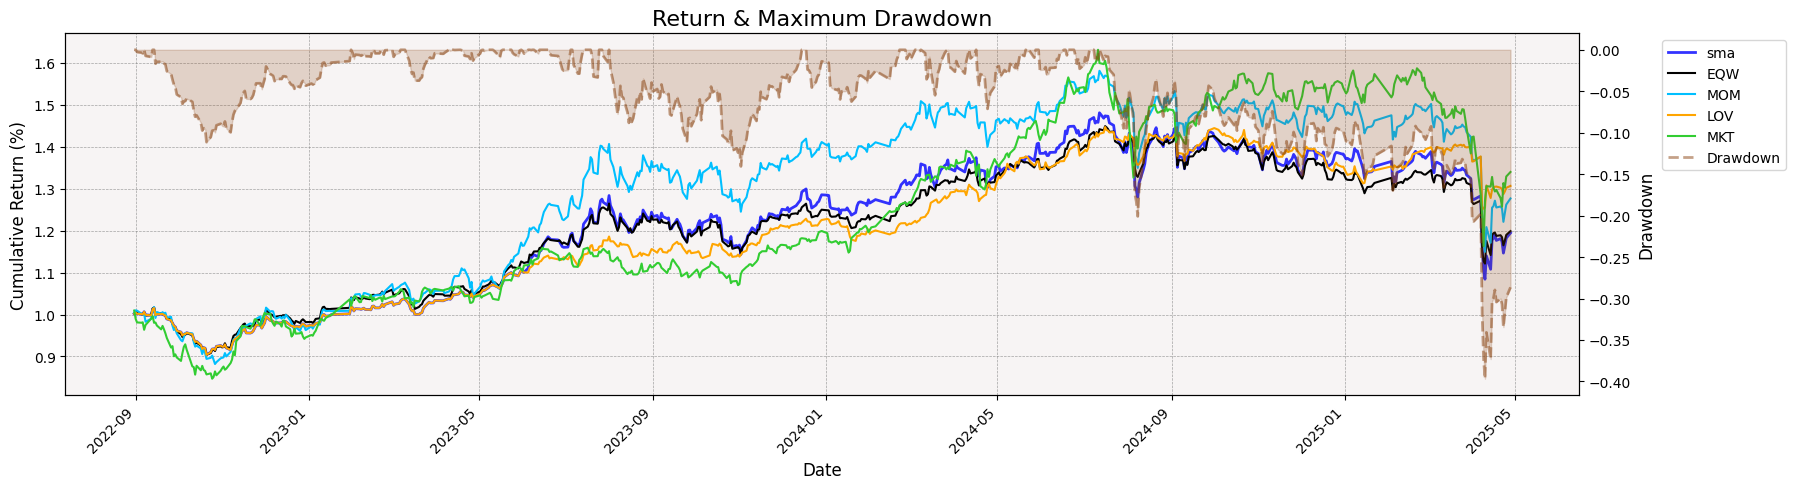

=========================================策略績效匯總（全樣本）================================================
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28
start_date: 2022-08-31
end_date: 2025-04-28


,年化收益率(%),年化標準差(%),年化夏普比率,索提諾比率,卡瑪比率,在市場上時間(%),最大回撤(MDD)(%),最長回撤日數,Profit Factor,日勝率(%),周勝率(%),月勝率(%),年勝率(%),偏態(Skewness),峰度(Kurtosis),Omega 比率,Tail Ratio
sma,7.25,17.93,0.48,0.64,0.27,100.0,-26.79,188.0,1.09,54.69,58.70,60.61,50.0,-1.2847,11.7470,1.09,0.92
EQW,7.40,14.47,0.57,0.74,0.33,100.0,-22.61,186.0,1.11,55.31,53.62,57.58,50.0,-1.8792,20.1165,1.11,0.96
MOM,10.09,20.11,0.58,0.78,0.37,100.0,-27.30,188.0,1.11,55.78,55.80,54.55,50.0,-0.9896,8.4995,1.11,0.87
LOV,11.10,11.63,0.96,1.25,0.82,100.0,-13.61,186.0,1.20,55.78,60.87,60.61,50.0,-3.1935,41.1815,1.20,1.07
MKT,12.21,20.74,0.66,0.91,0.43,100.0,-28.69,189.0,1.13,56.09,54.35,57.58,50.0,-0.7592,11.9262,1.13,1.09


In [41]:
###樣本內：'2008-6-18':'2022-08-31'
###樣本外：'2022-08-31':'2025-04-28'
###全樣本：'2008-6-18':'2025-04-28'
start_date = '2022-08-31'
end_date = '2025-04-28'
print('start_date:',start_date)
print('end_date:',end_date)
plot_compare_return(backtest_df['sma'].loc[start_date:end_date], backtest_df['EQW'].loc[start_date:end_date],backtest_df['MOM'].loc[start_date:end_date],backtest_df['LOV'].loc[start_date:end_date],backtest_df['MKT'].loc[start_date:end_date],strategy_label='sma',comparison_labels=['EQW','MOM','LOV','MKT'])
print('=========================================策略績效匯總（全樣本）================================================')
backtest_df.loc[start_date:end_date].apply(calculate_metrics).T

# vix加雙均線

In [42]:
vix_weight = pd.DataFrame(index=vix_data.index)
vix_weight['LOV'] = ((vix_data['最高價'] > 30) | (vix_data['最高價'] <= 10)).astype(float)
vix_weight['MOM'] = ((vix_data['最高價'] <= 30) & (vix_data['最高價'] > 10)).astype(float)
conbine_weight=weighting+vix_weight
conbine_weight_sum = conbine_weight.sum(axis=1)
conbine_weight = conbine_weight.div(conbine_weight_sum, axis=0)

In [43]:
###高波動市場給低波動因子 vs 低波動市場給動能因子
conbine_weight = conbine_weight.rename(columns={'高波動市場比率': '低波動因子','低波動市場比率':'動能因子'})
conbine_weight = conbine_weight[['低波動因子','動能因子']]

In [44]:
eqw_mega_factor=cs_cdf(factor_merge['低波動因子']*0.5+factor_merge['動能因子']*0.5)*cs_cdf(factor_merge['市值因子'])
mega_factor=cs_cdf(factor_merge['低波動因子'].mul(conbine_weight['低波動因子'],axis=0)+factor_merge['動能因子'].mul(conbine_weight['動能因子'],axis=0))*cs_cdf(factor_merge['市值因子'])
mom_facor=cs_cdf(factor_merge['動能因子'])*cs_cdf(factor_merge['市值因子'])
lov_factor=cs_cdf(factor_merge['低波動因子'])*cs_cdf(factor_merge['市值因子'])

In [ ]:
#倉位市值
aum_se, log_df=get_strategy_aum_se(factor=mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')#,plot_situation=True)
aum_se＿eqw, log_df_eqw=get_strategy_aum_se(factor=eqw_mega_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿mom, log_df_mom=get_strategy_aum_se(factor=mom_facor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')
aum_se＿lov, log_df_lov=get_strategy_aum_se(factor=lov_factor,aum=100000000,buy_fee=0.001425,sell_fee=0.001425+0.003,impact_coef=0.01,period='M')

#return_se
return_se=(aum_se['aum']/aum_se['aum'].shift(1)-1)
return_se＿eqw=(aum_se＿eqw['aum']/aum_se＿eqw['aum'].shift(1)-1)
return_se＿mom=(aum_se＿mom['aum']/aum_se＿mom['aum'].shift(1)-1)
return_se＿lov=(aum_se＿lov['aum']/aum_se＿lov['aum'].shift(1)-1)

###合成績效資料
backtest_df=pd.DataFrame()
backtest_df['combine']=return_se#.shift(2)
backtest_df['EQW']=return_se＿eqw#.shift(2)
backtest_df['MOM']=return_se＿mom#.shift(2)
backtest_df['LOV']=return_se＿lov#.shift(2)

backtest_df['MKT']=market_return
#market_return=market_return.loc['2008':'2025-04-28']
backtest_df=backtest_df.loc['2008':'2025-04-28'].fillna(0)

start_date: 2008-6-18
end_date: 2025-04-28


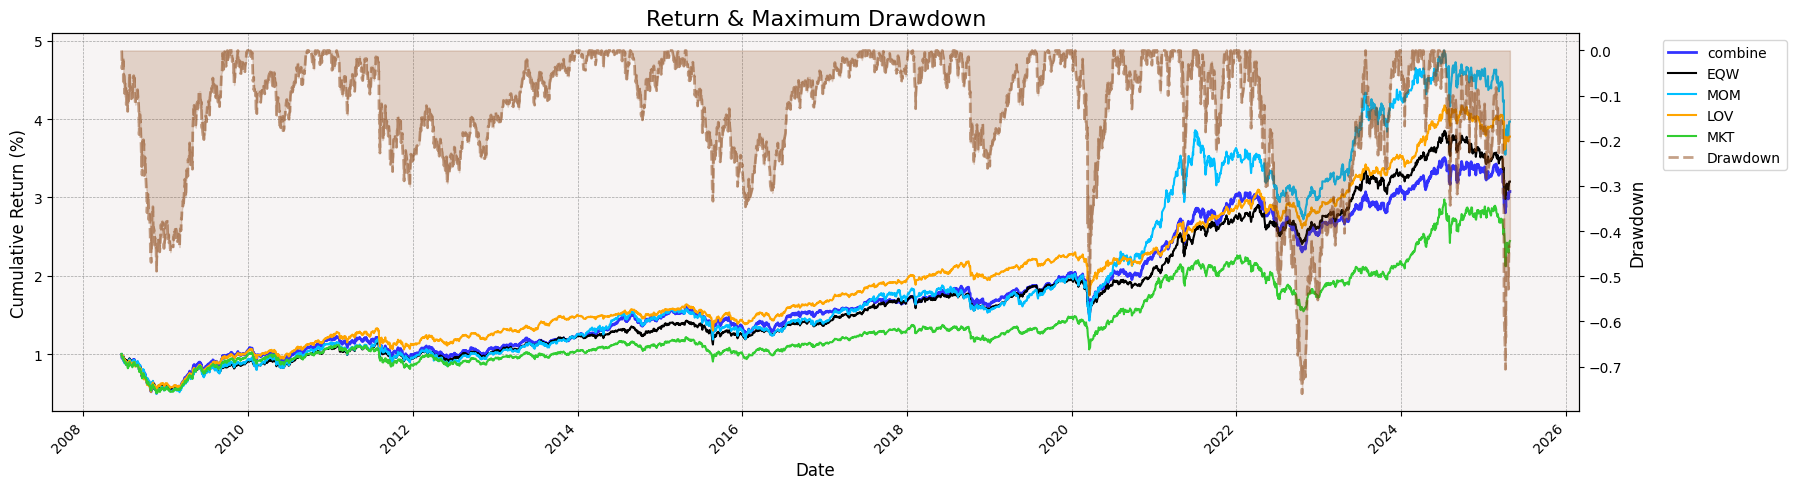

=========================================策略績效匯總（全樣本）================================================
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28
start_date: 2008-06-18
end_date: 2025-04-28


,年化收益率(%),年化標準差(%),年化夏普比率,索提諾比率,卡瑪比率,在市場上時間(%),最大回撤(MDD)(%),最長回撤日數,Profit Factor,日勝率(%),周勝率(%),月勝率(%),年勝率(%),偏態(Skewness),峰度(Kurtosis),Omega 比率,Tail Ratio
combine,7.07,19.09,0.45,0.63,0.14,99.98,-50.22,720.0,1.09,54.76,56.45,60.59,66.67,-0.3568,11.2579,1.09,0.96
EQW,7.34,17.40,0.49,0.67,0.16,99.98,-46.93,573.0,1.10,55.99,57.83,60.59,66.67,-0.6496,13.2434,1.10,0.92
MOM,8.75,21.92,0.49,0.67,0.17,99.98,-50.77,561.0,1.09,55.19,58.18,58.62,66.67,-0.4834,7.8703,1.09,0.88
LOV,8.42,15.35,0.60,0.82,0.17,99.98,-48.35,399.0,1.13,55.92,57.72,63.55,72.22,-0.7148,17.6926,1.13,0.94
MKT,5.58,18.35,0.39,0.53,0.11,100.00,-50.23,825.0,1.07,54.12,56.68,60.59,66.67,-0.4012,6.5409,1.07,0.92


In [46]:
###樣本內：'2008-6-18':'2022-08-31'
###樣本外：'2022-08-31':'2025-04-28'
###全樣本：'2008-6-18':'2025-04-28'
start_date = '2008-6-18'
end_date = '2025-04-28'
print('start_date:',start_date)
print('end_date:',end_date)
plot_compare_return(backtest_df['combine'].loc[start_date:end_date], backtest_df['EQW'].loc[start_date:end_date],backtest_df['MOM'].loc[start_date:end_date],backtest_df['LOV'].loc[start_date:end_date],backtest_df['MKT'].loc[start_date:end_date],strategy_label='combine',comparison_labels=['EQW','MOM','LOV','MKT'])
print('=========================================策略績效匯總（全樣本）================================================')
backtest_df.loc[start_date:end_date].apply(calculate_metrics).T